# Verificação das hipóteses relacionadas a taxa de cancelamento

## Verificação da hipótese 13

Hipótese 13: A porcentagem de cancelamento dos pedidos varia de acordo com o estado do endereço de entrega

### Definição do dataframe

In [1]:
from pyspark.sql import SparkSession, functions as F
spark = SparkSession.builder.getOrCreate()

orders_df = spark.read \
                 .option('escape', '\"') \
                 .option('quote', '\"') \
                 .csv('./dataset/olist_orders_dataset.csv', header=True, multiLine=True, inferSchema=True)

customers_df = spark.read \
                  .option('escape', '\"') \
                  .option('quote', '\"') \
                  .csv('./dataset/olist_customers_dataset.csv', header=True, multiLine=True, inferSchema=True)

In [2]:
df = orders_df.join(customers_df, orders_df.customer_id == customers_df.customer_id) \
                     .select('customer_state','order_status')

df.printSchema()

root
 |-- customer_state: string (nullable = true)
 |-- order_status: string (nullable = true)



### Contagem de pedidos por estados

In [3]:
df_all_orders = df.groupBy(F.col('customer_state')).count()
df_all_orders = df_all_orders.selectExpr('customer_state','count as all_orders_count')
df_all_orders.show()

+--------------+----------------+
|customer_state|all_orders_count|
+--------------+----------------+
|            SC|            3637|
|            RO|             253|
|            PI|             495|
|            AM|             148|
|            RR|              46|
|            GO|            2020|
|            TO|             280|
|            MT|             907|
|            SP|           41746|
|            ES|            2033|
|            PB|             536|
|            RS|            5466|
|            MS|             715|
|            AL|             413|
|            MG|           11635|
|            PA|             975|
|            BA|            3380|
|            SE|             350|
|            PE|            1652|
|            CE|            1336|
+--------------+----------------+
only showing top 20 rows



### Contagem de pedidos cancelados por estado

In [4]:
df_canceled = df.filter(F.col('order_status') == 'canceled')
df_canceled = df_canceled.groupBy(F.col('customer_state')).count()
df_canceled = df_canceled.selectExpr('customer_state','count as canceled_orders_count')
df_canceled.show()

+--------------+---------------------+
|customer_state|canceled_orders_count|
+--------------+---------------------+
|            SC|                   19|
|            RO|                    3|
|            PI|                    4|
|            RR|                    1|
|            GO|                   13|
|            TO|                    1|
|            MT|                    2|
|            SP|                  327|
|            ES|                    9|
|            PB|                    2|
|            RS|                   25|
|            MS|                    2|
|            AL|                    1|
|            MG|                   64|
|            PA|                    4|
|            BA|                   16|
|            SE|                    1|
|            PE|                    5|
|            CE|                    7|
|            RJ|                   86|
+--------------+---------------------+
only showing top 20 rows



### Calculo Porcentagem cancelados

In [5]:
df = df_canceled.join(df_all_orders, df_canceled.customer_state == df_all_orders.customer_state) \
    .select(df_canceled.customer_state,'canceled_orders_count','all_orders_count')

df = df.withColumn('canceled_percent', F.col('canceled_orders_count') / F.col('all_orders_count') *100) \
    .orderBy(F.desc('canceled_percent'))

df.show(50)

+--------------+---------------------+----------------+-------------------+
|customer_state|canceled_orders_count|all_orders_count|   canceled_percent|
+--------------+---------------------+----------------+-------------------+
|            RR|                    1|              46| 2.1739130434782608|
|            RO|                    3|             253|  1.185770750988142|
|            PI|                    4|             495| 0.8080808080808081|
|            SP|                  327|           41746| 0.7833085804627987|
|            RJ|                   86|           12852| 0.6691565515094927|
|            GO|                   13|            2020| 0.6435643564356436|
|            MG|                   64|           11635| 0.5500644606789857|
|            MA|                    4|             747|  0.535475234270415|
|            CE|                    7|            1336| 0.5239520958083832|
|            SC|                   19|            3637| 0.5224085784987627|
|           

### Exibição do gráfico

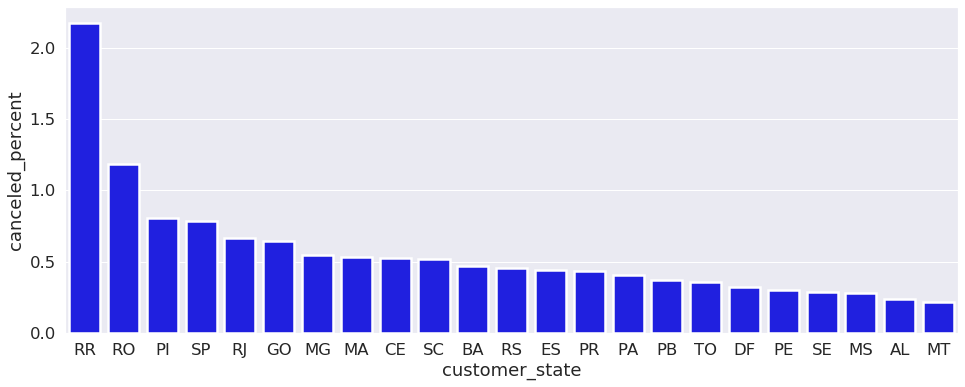

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
ax = sns.barplot(x='customer_state', y='canceled_percent', data=df.toPandas(), color='blue', linewidth=2.5)

## Conclusões

### A hipótese 13 é válida, pois a porcentagem de pedidos cancelados varia de acordo com a região, como por exemplo o estado de RR tem uma taxa de cancelamento maior do que em outros estados